In [1]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from agent import Agent

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/niklasschneider/Documents/projects/sop_projekt/venv/lib/pytho

In [2]:
LEARNING_RATE = 0.001

gamma = 0.999
max_num_episodes = 5000
hidden_size = [128, 64]

print_every = 100

In [3]:
env = gym.make('LunarLander-v3', continuous=False, enable_wind=False)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

threshold = env.spec.reward_threshold

agent = Agent(state_size, action_size, hidden_size, LEARNING_RATE, gamma)

In [4]:
def run_episode(env, agent):
    """Run a single episode of the environment with the agent. Return the rewards and log probabilities of the actions taken.
    
    Args:
        env: The environment to run the episode on.
        agent: The agent to use to select actions.
        
    Returns:
        rewards: A list of rewards received at each time step.
        log_probs: A list of log probabilities of the actions taken at each time step.
    """
    state = env.reset()[0]
    done = False
    log_probs = []
    rewards = []
    
    while not done:
        action, log_prob = agent.get_action(FloatTensor([state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        
        done = terminated or truncated
        
        if done:
            break
        
        state = next_state
        
    return rewards, log_probs

In [5]:

def train_agent(env, agent, max_num_episodes, print_every, threshold):
    """Train the agent on the environment.
    
    Args:
        env: The environment to train the agent on.
        agent: The agent to train.
        max_num_episodes: The maximum number of episodes to train for.
        print_every: The number of episodes to wait before printing the average reward.
        threshold: The reward threshold for the environment.
        
    Returns:
        episode_rewards: A list of rewards received at each episode.
    """
    scores_array = []
    avg_score_array = []
    cumulative_score = 0
    
    time_start = time.time()
    
    for episode in range(max_num_episodes):
        rewards, log_probs = run_episode(env, agent)
        agent.learn(rewards, log_probs)

        score = sum(rewards)
        scores_array.append(score)
        cumulative_score += score
        avg_score = cumulative_score / len(scores_array)
        avg_score_array.append(avg_score)
        
        if episode % print_every == 0:
            dt = int(time.time() - time_start)
            time_start = time.time()
            print(f"Episode {episode} - Score: {score} - Avg Score: {avg_score:.2f} - Time: {dt}s")
            
        if avg_score >= threshold:
            print(f"Environment solved in {episode} episodes with an average score of {avg_score:.2f}!")
            break
                
    return scores_array, avg_score_array

In [6]:
asd

NameError: name 'asd' is not defined

In [7]:
scores, avg_scores = train_agent(env, agent, max_num_episodes, print_every, threshold)

Episode 0 - Score: -166.70186828471464 - Avg Score: -166.70 - Time: 0s
Episode 100 - Score: -62.74315392084284 - Avg Score: -166.47 - Time: 7s
Episode 200 - Score: -116.64301989093171 - Avg Score: -146.85 - Time: 6s
Episode 300 - Score: -153.4514777984211 - Avg Score: -139.88 - Time: 7s
Episode 400 - Score: -43.082350929377185 - Avg Score: -120.98 - Time: 10s
Episode 500 - Score: -50.055377173464485 - Avg Score: -107.33 - Time: 20s
Episode 600 - Score: 0.35739373707043853 - Avg Score: -94.32 - Time: 28s
Episode 700 - Score: -26.029656262042757 - Avg Score: -82.28 - Time: 45s
Episode 800 - Score: 55.6604073894389 - Avg Score: -70.64 - Time: 37s
Episode 900 - Score: -140.65791239883103 - Avg Score: -61.29 - Time: 47s
Episode 1000 - Score: 3.9477962528302584 - Avg Score: -53.09 - Time: 35s
Episode 1100 - Score: -33.94777132244691 - Avg Score: -48.12 - Time: 8s
Episode 1200 - Score: 2.5395148532759464 - Avg Score: -42.28 - Time: 22s
Episode 1300 - Score: 75.7356516396633 - Avg Score: -35.8

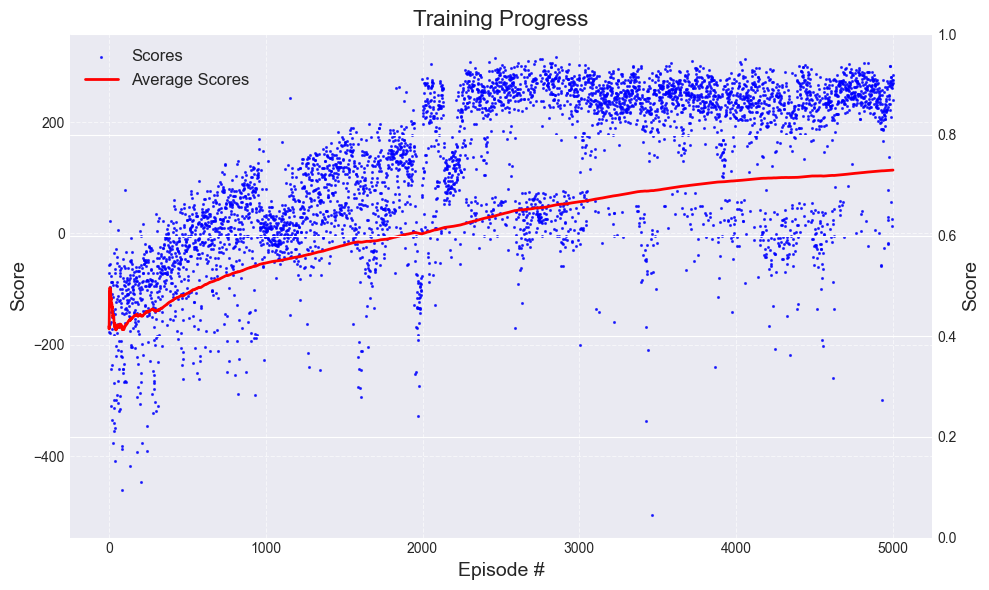

In [ ]:
plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(1, len(scores) + 1), scores, label="Scores", color="blue", alpha=0.7, s=1.5)
ax.plot(np.arange(1, len(avg_scores) + 1), avg_scores, label="Average Scores", color="red", linewidth=2)

ax.set_title("Training Progress", fontsize=16)
ax.set_xlabel("Episode #", fontsize=14)
ax.set_ylabel("Score", fontsize=14)

ax.legend(loc="best", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

ax2 = ax.twinx()
ax2.set_ylabel("Score", fontsize=14)
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()